# Deep Dive Tutorial: Data Modeling

## Learning Objectives

In this tutorial you will learn how to:
1. Create a catalog
2. Register tables
3. Analyse and set feature job settings
4. Define data cleaning operations
5. Define entities and table relationships
6. Create views of tables
7. Join views

## Set up the prerequisites

Learning Objectives

In this section you will:
* import libraries
* start your local featurebyte server

### Load the featurebyte library and connect to the local instance of featurebyte

In [ ]:
!pip install featurebyte
!wget https://raw.githubusercontent.com/featurebyte/featurebyte-hosted-tutorials/main/tutorials/notebooks/prebuilt_catalogs.py

In [ ]:
# library imports
import pandas as pd
import numpy as np
from datetime import datetime

# load the featurebyte SDK
import featurebyte as fb

print("FeatureByte version " + fb.version)

# inject your API token after registering for the tutorial
fb.register_tutorial_api_token("<api_token>")

2023-03-27 19:45:15.505 | INFO     | featurebyte.docker.manager:start_playground:305 | Starting featurebyte service | {}


FeatureByte version 0.1.4


2023-03-27 19:45:23.449 | INFO     | featurebyte.docker.manager:start_playground:307 | Starting local spark service | {}
2023-03-27 19:45:30.371 | INFO     | featurebyte.docker.manager:start_playground:310 | Starting documentation service | {}
2023-03-27 19:45:37.208 | INFO     | featurebyte.docker.manager:start_playground:314 | Creating local spark feature store | {}
2023-03-27 19:45:37.949 | INFO     | featurebyte.docker.manager:start_playground:336 | Dataset grocery already exists, skipping import | {}
2023-03-27 19:45:37.950 | INFO     | featurebyte.docker.manager:start_playground:336 | Dataset healthcare already exists, skipping import | {}
2023-03-27 19:45:37.950 | INFO     | featurebyte.docker.manager:start_playground:336 | Dataset creditcard already exists, skipping import | {}


## Create a catalog

Learning Objectives

In this section you will:
* learn about catalogs
* activate a new catalog

### Concept: Catalog

A FeatureByte Catalog serves as a centralized repository for storing metadata about FeatureByte objects such as tables, entities, features, and feature lists associated with a specific domain. It functions as an effective tool for facilitating collaboration among team members working on similar use cases or utilizing the same data source within a data warehouse.

### Concept: The default catalog

When you start Featurebyte, it automatically activates the default catalog. 

Do not use the default catalog for data modeling or feature engineering. Always create a new catalog or activate an existing catalog for your work.

### Example: Get the active catalog

In [2]:
# get the active catalog
catalog = fb.Catalog.get_active()

print(catalog.name)

default


### Example: Create a new catalog

In [3]:
catalog_name = "deep dive data modeling " + datetime.now().strftime("%Y%m%d:%H%M")
print(catalog_name)

# create a catalog
catalog = fb.Catalog.create(catalog_name)

deep dive data modeling 20230327:1945


### Example: Activate an existing catalog

In [4]:
# you can activate an existing catalog
catalog = fb.Catalog.activate(catalog_name)

## Register tables

Learning Objectives

In this section you will:
* be introduced to the case study dataset
* learn the about FeatureByte catalog table types
* declare FeatureByte catalog tables

### Case Study: French grocery dataset

The French grocery dataset contains four tables containing data from a chain of grocery stores.

The data source has already been declared in the playground feature store that was installed as part of FeatureByte.

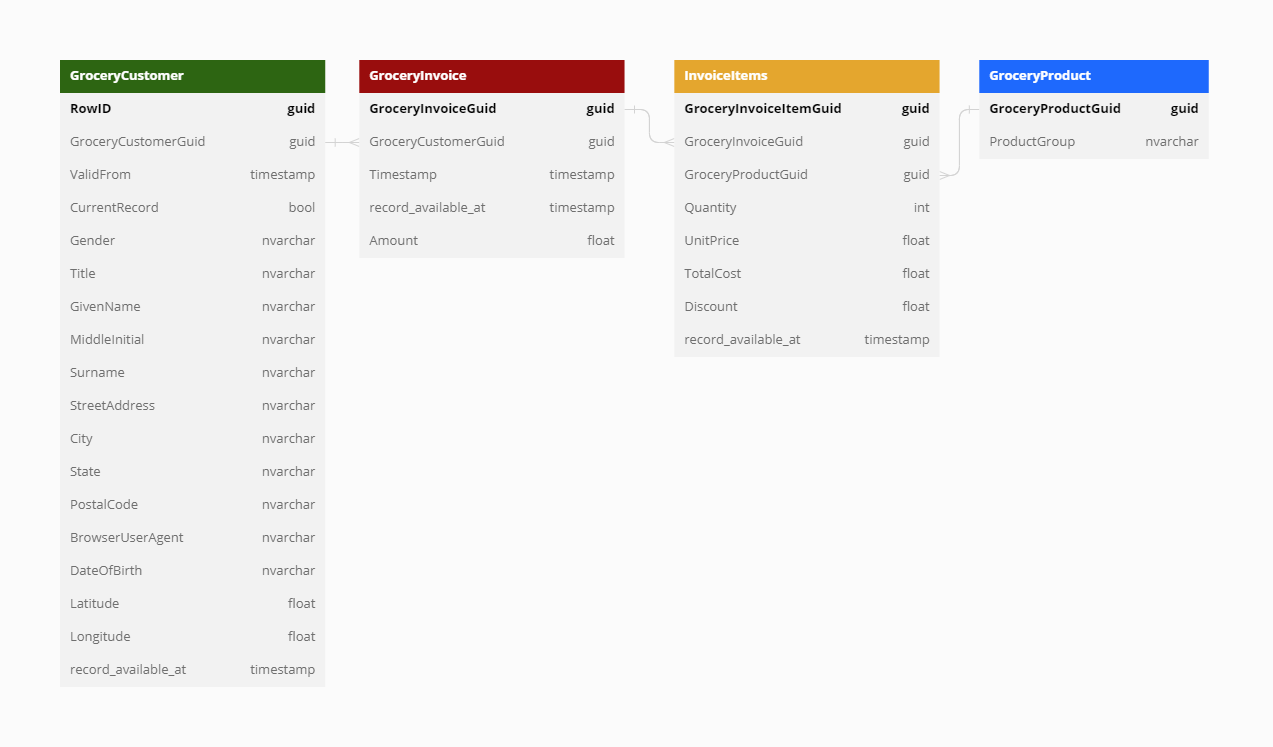

### Concept: Data source

A data source is a collection of tables accessible via a connection to a data warehouse or database. It is used to explore and retrieve details about tables that can be used as source table in the FeatureByte catalog. 

### Example: Connect to a pre-defined data source

In [5]:
# get data source from the local spark feature store
ds = fb.FeatureStore.get("playground").get_data_source()

# list the databases in the data source
ds.list_databases()

['spark_catalog']

In [6]:
# list all schemas in the spark catalog
ds.list_schemas('spark_catalog')

['creditcard', 'default', 'grocery', 'healthcare', 'playground']

In [7]:
# list the tables in the grocery schema
ds.list_tables('spark_catalog', 'grocery')

['__grocerycustomer',
 '__groceryinvoice',
 '__invoiceitems',
 'grocerycustomer',
 'groceryinvoice',
 'groceryproduct',
 'invoiceitems']

### Concept: Source table

A source table in FeatureByte is a table of interest located within the data warehouse. A source table is registered in FeatureByte as a type of Catalog Table in order to perform feature engineering on it.

### Concept: FeatureByte catalog table

A Catalog Table serves as a logical representation of a source table within the Catalog. The Catalog Table does not store data itself, but instead provides a way to access the source table and centralize essential metadata for feature engineering.

The metadata on the table’s type determines the types of feature engineering operations that are possible and enforce guardrails accordingly. 

### Concept: Slowly changing dimension (SCD) table

An SCD Table is a type of Catalog Table that represents a table in a data warehouse that contains data that changes slowly and unpredictably over time.

There are two main types of SCDs: Type 1, which overwrites old data with new data, and Type 2, which maintains a history of changes by creating a new record for each change. FeatureByte only supports the use of Type 2 SCDs since SCDs of Type 1 may cause data leaks during model training and poor performance during inference.

An SCD Table of Type 2 utilizes a natural key to distinguish each active row and facilitate tracking of changes over time. The SCD table employs effective and expiration date columns to determine the active status of a row. In certain instances, an active flag column may replace the expiration date column to indicate if a row is currently active.

To create an SCD Table in FeatureByte, it is necessary to identify columns for the natural key, effective timestamp, and optionally surrogate key, expiration timestamp, and active flag.

### Example: Declare a slowly changing dimension table

In [8]:
# declare the grocery customer table
customer_table = ds.get_table(
            database_name="spark_catalog",
            schema_name="GROCERY",
            table_name="GROCERYCUSTOMER"
        ).create_scd_table(
            name="GROCERYCUSTOMER",
                surrogate_key_column='RowID',
                natural_key_column="GroceryCustomerGuid",
                effective_timestamp_column="ValidFrom",
                current_flag_column ="CurrentRecord",
                record_creation_timestamp_column="record_available_at"
        )

# show the column names and types for grocery customer
ds.get_table(database_name="spark_catalog", schema_name="GROCERY", table_name="GROCERYCUSTOMER").dtypes

RowID                    VARCHAR
GroceryCustomerGuid      VARCHAR
ValidFrom              TIMESTAMP
Gender                   VARCHAR
Title                    VARCHAR
GivenName                VARCHAR
MiddleInitial            VARCHAR
Surname                  VARCHAR
StreetAddress            VARCHAR
City                     VARCHAR
State                    VARCHAR
PostalCode               VARCHAR
BrowserUserAgent         VARCHAR
DateOfBirth                 DATE
Latitude                   FLOAT
Longitude                  FLOAT
record_available_at    TIMESTAMP
CurrentRecord               BOOL
dtype: object

In [9]:
# show sample data
customer_table.sample(5)

,RowID,GroceryCustomerGuid,ValidFrom,Gender,Title,GivenName,MiddleInitial,Surname,StreetAddress,City,State,PostalCode,BrowserUserAgent,DateOfBirth,Latitude,Longitude,record_available_at,CurrentRecord
0,6e65a7d0-c88b-4283-b1d8-bdb5e8262e70,af30d1e6-1563-4866-9038-5a4c338f579d,2019-01-02 16:19:58,male,Mr.,Gaspar,L,Grenier,36 rue Petite Fusterie,BOURGOIN-JALLIEU,Rhône-Alpes,38300,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,2002-02-11,45.548451,5.319372,2019-01-02 17:01:00,True
1,66168ca8-ffb3-4ad3-82e7-3b3aecd08c86,bfee3b1a-4315-4a63-aff3-65e3f926fc41,2019-01-09 17:26:09,male,Mr.,Eustache,S,Lebel,82 avenue Voltaire,MALAKOFF,Île-de-France,92240,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1937-10-06,48.916850,2.213814,2019-01-09 18:01:00,True
2,170a2851-1d43-436d-b7f5-e856a2101dbf,9a6e097b-5297-4a31-b3a0-1443defb0915,2019-01-01 16:53:27,male,Mr.,William,C,Arnoux,11 Place Charles de Gaulle,VILLENEUVE-D'ASCQ,Nord-Pas-de-Calais,59493,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,1994-07-23,50.521505,3.111618,2019-01-01 17:01:00,True
3,d71980f1-f487-4b8d-bbd5-aaf93d628250,832a37b2-0a10-4f78-be47-42415f68be6c,2019-01-15 12:50:46,male,Mr.,Forrest,F,Cuillerier,99 rue Victor Hugo,COUDEKERQUE-BRANCHE,Nord-Pas-de-Calais,59210,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,1998-12-11,51.065044,2.435192,2019-01-15 13:01:00,True
4,d8124824-6d48-44c4-bbc5-36a833c1f316,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2019-01-02 15:18:35,female,Mrs.,Baptiste,B,Monty,48 rue Michel Ange,LE LAMENTIN,Martinique,97232,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,1996-06-15,14.683413,-61.069866,2019-01-02 16:01:00,True


### Concept: Event table

An Event table is a type of Catalog Table that represents a Transaction Fact Table in the data warehouse. Each row in this table indicates a specific business event that was measured at a particular moment in time.

Event tables can take various forms, such as an Order table in E-commerce, Credit Card Transactions in Banking, Doctor Visits in Healthcare, and Clickstream on the Internet.

To create an Event Table in FeatureByte, it is necessary to identify the columns that represent the event key and the event timestamp.

Additionally, the column that represents the record creation timestamp may be identified to enable an automatic analysis of data availability and freshness of the source table. This analysis can assist in selecting the default scheduling of the computation of features associated with the Event table.

### Example: Declare an event table

In [10]:
# register GroceryInvoice as an event data
invoice_table = ds.get_table(
            database_name="spark_catalog",
            schema_name="GROCERY",
            table_name="GROCERYINVOICE"
        ).create_event_table(   
            name="GROCERYINVOICE",
            event_id_column="GroceryInvoiceGuid",
            event_timestamp_column="Timestamp",
            record_creation_timestamp_column="record_available_at"
        )

# show the column names and types for grocery invoice
ds.get_table(database_name="spark_catalog", schema_name="GROCERY", table_name="GROCERYINVOICE").dtypes

GroceryInvoiceGuid       VARCHAR
GroceryCustomerGuid      VARCHAR
Timestamp              TIMESTAMP
record_available_at    TIMESTAMP
Amount                     FLOAT
dtype: object

In [11]:
invoice_table.preview()

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,record_available_at,Amount
0,4fccfb1d-02b3-4047-87ab-4e5f910ccdd1,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-03 12:28:58,2022-01-03 13:01:00,10.68
1,9cf3c416-7b38-401e-adf6-1bd26650d1d6,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-03 16:32:15,2022-01-03 17:01:00,38.04
2,0a5b99b2-9ff1-452a-a06e-669e8ed4a9fa,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-07 16:20:04,2022-01-07 17:01:00,1.99
3,e179f124-bcae-438f-af90-47b0adb32b54,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-10 16:18:32,2022-01-10 17:01:00,37.21
4,c83182ff-b8b9-4f11-9aa0-7b33b828bfd1,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-12 17:36:23,2022-01-12 18:01:00,1.20
5,d08923e9-4364-466b-957d-fd5552e7a4be,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-17 17:24:22,2022-01-17 18:01:00,45.42
6,177a7e13-e806-4b0e-8a5a-dab98e6104f9,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-18 15:42:02,2022-01-18 16:01:00,1.25
7,154bdc8b-08c9-499f-b589-7a66d5bdeed9,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-22 20:28:27,2022-01-22 21:01:00,2.00
8,451876a2-2a04-45cf-9f61-210dd0f4f655,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-25 11:49:23,2022-01-25 12:01:00,33.87
9,b0255f0b-9a44-4393-91d5-1a6a84750089,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-01-26 18:43:31,2022-01-26 19:01:00,16.15


In [12]:
# show sample data
invoice_table.sample(5)

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,record_available_at,Amount
0,09384ec7-f3a4-466e-bc8e-41023937354b,7005c3a2-a903-4c15-9ffb-d52b0d5eba14,2022-10-31 15:05:32,2022-10-31 16:01:00,2.89
1,381522c8-55b3-4015-9ce2-938ea8828683,82a104d2-ad63-4079-8ccc-767c5b88afcb,2022-11-17 15:24:37,2022-11-17 16:01:00,3.74
2,d687e93b-557e-49f6-a412-095c4448f305,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2022-03-03 21:04:48,2022-03-03 22:01:00,48.18
3,530bd051-e009-42f0-b598-13e3947a4b46,ebd6f63f-9425-4175-8f69-457979d69741,2022-06-13 16:53:28,2022-06-13 17:01:00,25.97
4,812ad0a9-dbfc-4579-8a87-0495614ee8d1,b721fbac-ed20-47c7-8bcc-c7033dddf773,2022-11-20 15:42:00,2022-11-20 16:01:00,27.57


### Concept: Item table

An Item table is a type of Catalog Table that represents a table in the data warehouse containing in-depth details about a business event.

For instance, an Item table can contain information about Product Items purchased in Customer Orders or Drug Prescriptions issued during Doctor Visits by Patients.

Typically, an Item table has a 'one-to-many' relationship with an Event table. Despite not explicitly including a timestamp, it is inherently linked to an event timestamp through its association with the Event table.

To create an Item Table, it is necessary to identify the columns that represent the item key and the event key and determine which Event table is associated with the Item table.

### Example: Declare an item table

In [13]:
# register invoice items as an item table
items_table = ds.get_table(
            database_name="spark_catalog",
            schema_name="GROCERY",
            table_name="INVOICEITEMS"
        ).create_item_table(
            name="INVOICEITEMS",
            event_id_column="GroceryInvoiceGuid",
            item_id_column="GroceryInvoiceItemGuid",
            event_table_name="GROCERYINVOICE"
        )

# show the column names and types for invoice items
ds.get_table(database_name="spark_catalog", schema_name="GROCERY", table_name="INVOICEITEMS").dtypes

GroceryInvoiceItemGuid      VARCHAR
GroceryInvoiceGuid          VARCHAR
GroceryProductGuid          VARCHAR
Quantity                      FLOAT
UnitPrice                     FLOAT
TotalCost                     FLOAT
Discount                      FLOAT
record_available_at       TIMESTAMP
dtype: object

In [14]:
# show sample data
items_table.sample(5)

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at
0,e7e96e3c-ef4e-4644-903a-ca378a5860b8,a90aa7d8-a41b-4841-adcf-59178e0f0eea,2f5694f4-d6ca-4bfa-adbc-6a3750406306,1.0,0.88,0.88,0.41,2022-07-26 22:01:00
1,d62dccc6-748d-4396-83e0-f3755849061e,ac1123e2-7052-4669-a956-e3057fb1f064,663e9a7b-7e86-48fe-9033-d52607caa602,1.0,3.49,3.49,0.00,2022-06-23 19:01:00
2,70f7bf5a-e6f6-471b-9ebf-5a060e0f6791,b3e69b48-83e7-42c2-a3ce-2158d73ec21c,d139e012-49a1-4fd6-b2f5-bb32556d1d36,1.0,1.00,1.00,0.00,2022-02-23 15:01:00
3,988de65a-be63-4018-b4fe-8b5b649795f0,7c476831-468f-44c0-b3f0-2e8a87df8b65,fb815fd5-9199-4984-a24d-edb489708a03,1.0,0.79,0.79,0.30,2022-03-17 17:01:00
4,e156d9af-0e71-4739-8fd8-c3a0fbbde824,15c13a4e-c5ca-473d-99a0-c52e3739e52c,ed646a2f-78d4-4757-88b0-b1ffbac41293,1.0,4.99,4.99,1.50,2022-04-27 20:01:00


### Concept: Dimension table

A Dimension table is a Catalog Table that represents a table in the data warehouse that stores static descriptive information such as a birth date.

Using a Dimension table requires special attention. If the data in the table changes slowly, it is not advisable to use it because these changes can cause significant data leaks during model training and adversely affect the inference performance. In such cases, it is recommended to use a Slowly Changing Dimension table of Type 2 that maintains a history of changes.

To create a Dimension Table in FeatureByte, it is necessary to identify which column represents the primary key.

In [15]:
# register GroceryProduct as a dimension table
product_table = ds.get_table(
            database_name="spark_catalog",
            schema_name="GROCERY",
            table_name="GROCERYPRODUCT"
        ).create_dimension_table(
            name="GROCERYPRODUCT",
            dimension_id_column="GroceryProductGuid"
        )

# show the column names and types for grocery product
ds.get_table(database_name="spark_catalog", schema_name="GROCERY", table_name="GROCERYPRODUCT").dtypes

GroceryProductGuid    VARCHAR
ProductGroup          VARCHAR
dtype: object

In [16]:
# show sample data
product_table.sample(5)

,GroceryProductGuid,ProductGroup
0,e890c5cb-689b-4caf-8e49-6b97bb9420c0,Épices
1,5720e4df-2996-4443-a1bc-3d896bf98140,Chat
2,96fc4d80-8cb0-4f1b-af01-e71ad7e7104a,Pains
3,d34a6792-4df4-46b2-87d2-bb92ca9bad42,Vinaigres
4,08c8fc05-27b7-4a68-890f-eea546a97ac0,Frites et Pommes de terre


## Analyse and set feature job settings

Learning Objectives

In this section you will:
* learn about feature jobs
* analyze data to estimate optimal feature job settings
* declare feature job settings

### Background

FeatureByte is designed to work with data warehouses that receive regular data refreshes from operational sources, which means that feature values may differ in terms of freshness and availability. If these operational limitations are not taken into account, inconsistencies between offline and online feature values may occur.

To prevent such inconsistencies, it's crucial to synchronize the frequency of batch feature computations with the frequency of source table refreshes, and to compute features after the source table refresh is fully completed. In addition, for historical serving to accurately replicate the production environment, it's essential to use data that was available at the historical points-in-time, considering the present or future latency of data. Latency of data refers to the time difference between the timestamp of an event and the timestamp at which the event data is accessible for ingestion. Any period during which data may be missing is referred to as a "blind spot".

To address these challenges, the Feature Job Setting in FeatureByte captures information about the frequency of batch feature computations, the timing of the batch process, and the assumed blind spot for the data. This helps ensure consistency between offline and online feature values, and accurate historical serving that reflects the conditions present in the production environment.

### Concept: Feature job

A Feature Job is a batch process that generates both offline and online tiles and feature values for a specific feature before storing them in the feature store. The scheduling of a Feature Job is determined by the feature job settings associated with the respective feature.

Feature job orchestration is initiated when a feature is deployed and continues until the feature deployment is disabled, ensuring the feature store consistently possesses the latest values for each feature.

### Concept: Feature job setting

The Feature Job Setting in FeatureByte captures essential details about batch feature computations for the online feature store, including the frequency and timing of the batch process, as well as the assumed blind spot for the data. This helps to maintain consistency between offline and online feature values and ensures accurate historical serving that reflects the production environment. The setting comprises three parameters:
1. The frequency parameter specifies how often the batch process should run.
2. The time_modulo_frequency parameter defines the timing from the end of the frequency time period to when the feature job commences. For example, a feature job with the following settings (frequency 60m, time_modulo_frequency: 130s) will start 2 min and 10 seconds after the beginning of each hour: 00:02:10, 01:02:10, 02:02:10, …,  15:02:10, …, 23:02:10.
3. The blind_spot parameter sets the time gap between feature computation and the latest event timestamp to be processed.

Case study: A data warehouse refreshes each hour. The data refresh starts 10 seconds after the hour and is usually finished within 2 minutes. Sometimes the data refresh misses the latest data, up to a maximum of the last 30 seconds at the end of the hour. Therefore the feature job settings will be:
* frequency: 60m
* time_modulo_frequency: 10s + 2m + 5s (a safety buffer) = 135s
* blind_spot: 30s + 10s + 2m + 5s = 165s

To accommodate changes in source data management, Feature Job Setting supports versioning of both features and feature lists. The scheduling information and blind spot are stored in the Feature Job Setting metadata associated with each feature.

While Feature Jobs are primarily designed to support online requests, this information is also used during historical requests to minimize offline-online inconsistency.

### Concept: Feature job setting recommendations

FeatureByte automatically analyzes data availability and freshness of an event table in order to suggest an optimal setting for scheduling Feature Jobs and associated Blind Spot information.

This analysis relies on the presence of record creation timestamps in the source table, typically added when updating data in the warehouse. The analysis focuses on a recent time window, such as the past four weeks.

FeatureByte estimates the data update frequency based on the distribution of time intervals among the sequence of record creation timestamps. It also assesses the timeliness of source table updates and identifies late jobs using an outlier detection algorithm. By default, the recommended scheduling time takes late jobs into account.

To accommodate data that may not arrive on time during warehouse updates, a blind spot is proposed for determining the cutoff for feature aggregation windows, in addition to scheduling frequency and time of the Feature Job. The suggested blind spot offers a percentage of late data closest to the user-defined tolerance, with a default of 0.005%.

To validate the Feature Job schedule and blind spot recommendations, a backtest is conducted. Users can also backtest their own settings.

### Example: Feature job settings analysis

In [17]:
# initialize the feature job settings for the invoice table
invoice_table.initialize_default_feature_job_setting()

Done! |████████████████████████████████████████| 100% in 9.3s (10.78%/s)                                                


### Concept: Default Feature Job Setting

The Default Feature Job Setting establishes the default setting used by features that aggregate data in a table, ensuring consistency of the Feature Job Setting across features created by different team members. While it's possible to override the setting during feature declaration, using the Default Feature Job Setting simplifies the process of setting up the Feature Job Setting for each feature.

### Example: View a default feature job setting

In [18]:
# display the default feature job setting for the invoice table
print(invoice_table.default_feature_job_setting)

blind_spot='120s' frequency='3600s' time_modulo_frequency='65s'


### Example: Manually override a default feature job setting

* The frequency parameter specifies how often the batch process should run.
* The time_modulo_frequency parameter defines the timing of the batch process.
* The blind_spot parameter sets the time gap between feature computation and the latest event timestamp to be processed.

In [19]:
# set a more conservative feature job setting for the invoice table
manual_setting = fb.FeatureJobSetting(
    blind_spot="135s",
    frequency="60m",
    time_modulo_frequency="90s",
)
invoice_table.update_default_feature_job_setting(manual_setting)

## Define data cleaning operations

Learning Objectives

In this section you will:
* learn the different types of cleaning operations supported by FeatureByte
* declare cleaning operations

### Concept: Cleaning operations

Cleaning operations determine the process for cleaning data in a table column before performing feature engineering. The cleaning operations can either be set as a default operation in the metadata of a table column or established when creating a view.

These operations specify how to manage the following scenarios:
* Missing values
* Disguised values
* Values that are not in an anticipated list
* Numeric values and dates that are out of boundaries

It is important to note that cleaning operations for a specific table column may consist of a sequence of operations, which are executed in a particular order. Imputed values from previous operations should not be identified as values to be cleaned in subsequent operations.

### Example: Correct negative discounts and missing discount amounts

In [20]:
# discount amount cannot be negative
items_table.Discount.update_critical_data_info(
    cleaning_operations=[
        fb.MissingValueImputation(imputed_value=0),
        fb.ValueBeyondEndpointImputation(type="less_than", end_point=0, imputed_value=0),
    ]
)

### Example: Remove infinite prices

In [21]:
# fix infinite unit price by removing these values
items_table.UnitPrice.update_critical_data_info(
    cleaning_operations=[
        fb.ValueBeyondEndpointImputation(type="greater_than", end_point=100000, imputed_value=None),
    ]
)

## Define entities and table relationships

Learning Objectives

In this section you will:
* learn the purpose of entities
* declare entities
* tag table columns with their associated entities

### Concept: Entity

An entity is a real-world object or concept that is represented by fields in source tables. Entities facilitate automatic table join definitions, serve as the unit of analysis for feature engineering, and aid in organizing features, feature lists, and use cases. Examples of entities can include customers, merchants, cities, products, and orders.

Before features can be assigned to an entity, the user must identify the relevant columns in the Catalog Tables that define or refer to the entity. This is done through “tagging” columns with their semantic information.

### Concept: Entity serving name

An entity's serving name is the name of the unique identifier that is used to identify the entity during a preview or serving request. Typically, the serving name for an entity is the name of the primary key (or natural key) of the table that represents the entity. For convenience, an entity can have multiple serving names but the unique identifier should remain unique.

### Example: Declare new entities

In [22]:
entity1 = catalog.create_entity(name="grocerycustomer", serving_names=["GROCERYCUSTOMERGUID"])
entity2 = catalog.create_entity(name="groceryinvoice", serving_names=["GROCERYINVOICEGUID"])
entity3 = catalog.create_entity(name="groceryproduct", serving_names=["GROCERYPRODUCTGUID"])
entity4 = catalog.create_entity(name="frenchstate", serving_names=["FRENCHSTATE"])

### Concept: Entity Tagging

The process of entity tagging involves identifying the specific columns in tables that  identify or reference a particular entity. These columns are often primary keys, natural keys, or foreign keys that are unique to each entity. This process is a critical step in preparing data before feature engineering, as it enables users to assign features to individual entities or join related data across multiple tables.

### Example: Entity tagging

In [23]:
# tag the entities for the grocery customer table
customer_table.GroceryCustomerGuid.as_entity("grocerycustomer")
customer_table.State.as_entity("frenchstate")

# tag the entities for the grocery invoice table
invoice_table.GroceryInvoiceGuid.as_entity("groceryinvoice")
invoice_table.GroceryCustomerGuid.as_entity("grocerycustomer")

# tag the entities for the grocery items table
items_table.GroceryInvoiceGuid.as_entity("groceryinvoice")
items_table.GroceryProductGuid.as_entity("groceryproduct")

# tag the entities for the grocery items table
product_table.GroceryProductGuid.as_entity("groceryproduct")

### Concept: Entity Relationship

Entity relationships can assist feature engineering and feature serving. 

The parent-child relationship is automatically established in FeatureByte during the entity tagging process, while identifying supertype-subtype relationships require manual intervention.

Both types are valuable information sources that can be utilized in feature engineering and feature serving. By leveraging these relationships, it becomes possible to suggest, facilitate and verify joins during feature engineering and streamline the process of serving feature lists containing multiple entity-assigned features.

### Concept: Parent-Child Relationship

A parent-child relationship is a hierarchical connection that links one entity (the child) to another entity (the parent). Each child entity key value can have only one parent entity key value, but a parent entity key value can have multiple child entity key values.

Examples of parent-child relationships include:

* Hierarchical organization chart: A company's employees are arranged in a hierarchy, with each employee having a manager. The employee entity represents the child, and the manager entity represents the parent.
* Product catalog: In an e-commerce system, a product catalog may be categorized into subcategories and categories. Each category or subcategory represents a child of its parent category.
* Geographical hierarchy: In a geographical data model, cities are arranged in states, which are arranged in countries. Each city is the child of its parent state, and each state is the child of its parent country.

In FeatureByte, this relationship is automatically established when the primary key (or natural key in the context of a SCD table) identifies one entity. This entity is the child entity. Other entities that are referenced in the table are identified as the parent entities.



### Example: Display entity relationships

In [24]:
# list the entity relationships
catalog.list_relationships()

,id,relationship_type,primary_entity,related_entity,primary_data_source,primary_data_type,is_enabled,created_at,updated_at
0,642181fc9bd87982bb5c996b,child_parent,groceryinvoice,grocerycustomer,GROCERYINVOICE,event_table,True,2023-03-27 11:46:04.827,None
1,642181fc02047323e03438ad,child_parent,grocerycustomer,frenchstate,GROCERYCUSTOMER,scd_table,True,2023-03-27 11:46:04.311,None


## Create views of tables

Learning Objectives

In this section you will:
* learn the purpose of views
* create views from tables
* transform data in a view
* filter rows in a view

### Concept: FeatureByte Views

Views are cleaned versions of Catalog tables and offer a flexible and efficient way to work with Catalog tables. They allow operations like creating new columns, filtering records, conditionally editing columns, extracting lags, capturing attribute changes, and joining views, similar to Pandas. Unlike Pandas DataFrames, which require loading all data into memory, views are materialized only when needed during previews or feature materialization.

When a view is created, it inherits the metadata of the Catalog Table it originated from. There are currently five types of views supported: Event Views, Item Views, Dimension Views, Slowly Changing Dimension (SCD) Views, and Change Views.

The syntax used to manipulate data in a FeatureByte view is similar to a Pandas DataFrame, making it easier to learn.

By default, data accessed through views is cleaned according to the default cleaning operations specified in the Catalog Tables. However, it is still possible to perform data manipulation based on the raw data present in the source table using the raw view attribute or to overwrite the cleaning operations when the view is created.

View operations are only materialized for purposes such as samples, exploratory data analysis, or feature materialization. FeatureByte follows a lazy execution strategy where view operations are translated into a graphical representation of intended operations.

### Example: Create views from tables

In [25]:
# get the view objects
product_view = product_table.get_view()
items_view = items_table.get_view()
invoice_view = invoice_table.get_view()
customer_view = customer_table.get_view()

In [26]:
# display the customer view
customer_view.sample(5)

,RowID,GroceryCustomerGuid,ValidFrom,Gender,Title,GivenName,MiddleInitial,Surname,StreetAddress,City,State,PostalCode,BrowserUserAgent,DateOfBirth,Latitude,Longitude,CurrentRecord
0,6e65a7d0-c88b-4283-b1d8-bdb5e8262e70,af30d1e6-1563-4866-9038-5a4c338f579d,2019-01-02 16:19:58,male,Mr.,Gaspar,L,Grenier,36 rue Petite Fusterie,BOURGOIN-JALLIEU,Rhône-Alpes,38300,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,2002-02-11,45.548451,5.319372,True
1,66168ca8-ffb3-4ad3-82e7-3b3aecd08c86,bfee3b1a-4315-4a63-aff3-65e3f926fc41,2019-01-09 17:26:09,male,Mr.,Eustache,S,Lebel,82 avenue Voltaire,MALAKOFF,Île-de-France,92240,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1937-10-06,48.916850,2.213814,True
2,170a2851-1d43-436d-b7f5-e856a2101dbf,9a6e097b-5297-4a31-b3a0-1443defb0915,2019-01-01 16:53:27,male,Mr.,William,C,Arnoux,11 Place Charles de Gaulle,VILLENEUVE-D'ASCQ,Nord-Pas-de-Calais,59493,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,1994-07-23,50.521505,3.111618,True
3,d71980f1-f487-4b8d-bbd5-aaf93d628250,832a37b2-0a10-4f78-be47-42415f68be6c,2019-01-15 12:50:46,male,Mr.,Forrest,F,Cuillerier,99 rue Victor Hugo,COUDEKERQUE-BRANCHE,Nord-Pas-de-Calais,59210,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,1998-12-11,51.065044,2.435192,True
4,d8124824-6d48-44c4-bbc5-36a833c1f316,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2019-01-02 15:18:35,female,Mrs.,Baptiste,B,Monty,48 rue Michel Ange,LE LAMENTIN,Martinique,97232,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,1996-06-15,14.683413,-61.069866,True


### Example: Transform data in a view

In [27]:
# extract the operating system from the BrowserUserAgent column
customer_view["OperatingSystemIsWindows"] = customer_view.BrowserUserAgent.str.contains("Windows")

# display a sample of the results
display(customer_view[["GroceryCustomerGuid", "BrowserUserAgent", "OperatingSystemIsWindows"]].sample())

,GroceryCustomerGuid,ValidFrom,BrowserUserAgent,CurrentRecord,OperatingSystemIsWindows
0,af30d1e6-1563-4866-9038-5a4c338f579d,2019-01-02 16:19:58,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,True,True
1,bfee3b1a-4315-4a63-aff3-65e3f926fc41,2019-01-09 17:26:09,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,True,True
2,9a6e097b-5297-4a31-b3a0-1443defb0915,2019-01-01 16:53:27,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,True,True
3,832a37b2-0a10-4f78-be47-42415f68be6c,2019-01-15 12:50:46,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,True,False
4,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2019-01-02 15:18:35,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,True,False
5,e3a927ee-ae24-496d-9c53-53f39ede0f9e,2019-03-16 17:22:56,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,True,True
6,cbc46908-6827-49b5-8cbc-c67223ca56c4,2019-01-07 16:44:43,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,True,True
7,e0df64b7-9104-439d-956e-dc5dc0a66f8f,2019-01-08 10:50:07,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,False,True
8,372f9d62-7479-43c4-a54c-8b49faff067c,2021-04-21 17:12:29,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:66...,True,True
9,850e590f-d786-4dd3-9c3f-836aa1402091,2022-03-24 15:24:04,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,True,True


### Example: Filtering a view

The syntax for filtering a view is the same as pandas.

In [28]:
# create a filter for filtering rows to see only small purchases
filter = invoice_view["Amount"] < 2
filtered_invoice_view = invoice_view[filter]

display(filtered_invoice_view.sample())

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,Amount
0,b70a72fb-a433-459d-9044-d203f356849c,8eb8be21-9669-406a-9cb6-b491274b421c,2022-02-08 20:46:37,1.25
1,0b8356a0-27c4-4b34-944e-38fb998f2dc6,7309a1f3-7e27-41e0-a8c4-d51c4576da5e,2023-03-08 15:07:34,1.59
2,36807f40-387d-41cf-a5af-70231226ade2,c5820998-e779-4d62-ab8b-79ef0dfd841b,2022-07-30 16:07:56,1.98
3,ca049b97-d889-4dc8-8959-318f087f12d2,98900f2c-9dc1-456f-a47d-cf6a8f852b90,2022-11-16 14:39:22,1.00
4,31ea244a-bc1e-461f-9cae-61037b0a42f5,96a7e1e2-c5e8-4b1e-bc57-1d5542b9da7b,2023-02-09 20:02:32,1.99
5,dc70ad4b-9795-4a9f-b45e-9c0a23d8dea0,eec9351c-7ffc-44ee-b330-f3652aa87f5a,2022-12-02 18:04:24,1.11
6,926732c5-c322-4a97-9940-05c9bf6aac9c,6020fee1-bfa0-4683-89f4-d5adf66c89c3,2022-06-25 14:22:44,1.95
7,36fa9ee9-3d20-4d9d-b894-3d2fe0896b69,4c9d0466-4859-4ab8-acee-d4fd58ced70b,2023-02-02 17:33:22,1.77
8,f07a4540-e45e-45e0-a829-9dbb0e2d26c7,b0a55592-2b89-4b03-a963-d93a35f2e3a4,2023-02-05 16:30:39,1.29
9,e846df2f-c2ca-48ae-91b9-9e01534d212d,29a9d057-dc13-41cd-8784-d622749074f0,2022-11-01 08:55:15,1.98


## Join views

Learning Objectives

In this section you will learn:
* how views are joined
* the purpose of natural keys
* which view types can be joined
* how joins are frequently unnecessary

### Concept: Principles of featurebyte joins

In featurebyte:
* Joins operate on views
* Join criteria by common entities, and by event timestamps for joins of event views and slowly changing data
* Similarly to pandas, for the right-hand-side view, the join key must be its index (its natural key).
* Joins add columns to an existing view
* Joins never increase the number of rows in a view.
* By default, the number of rows do not change after a join. However, the number of rows may reduce if an inner join is selected.
* Only one-to-one and many-to-one relationships are supported. One-to-many and many-to-many relationships are not supported.
* Always start with the view that has the <b>many</b> side of the relationship, then join the view that has the <b>one</b> side of the relationship
* Similarly to a left join, rows with no match will contain missing values for the joined fields

### Concept: Natural key

A natural key is a key that is based on data that already exists within the table, such as a customer ID, or employee’s social security number. In a Slowly Changing Dimension (SCD) table, a natural key is a field or a group of fields that remains constant over time and uniquely identifies each active row in the table at any point-in-time.

### Concept: View joins

A view join is the process of combining two or more views into a single view based on a related entity. Like pandas, the calling view primary key is preserved through joins. The entity referred to by the primary key (or natural key for a SCD) in the joining view and the foreign key in the calling view should be the same.

### Example: Join event data to item data

Event data is automatically joined to item data via the event ID.

When an ItemView is created, the event_timestamp and the entities of the event data the item data is associated with are automatically added. Featurebyte automatically joins the parent event's entity and timestamp to the item view.

The preferred method to add columns from the event view is the join_event_data_attributes method.

In [29]:
# copy the invoice amount into the items view
items_view.join_event_table_attributes(['Amount'], event_suffix='_invoice_total')

display(items_view.preview())

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at,GroceryCustomerGuid,Timestamp,Amount_invoice_total
0,d8ce1ccf-dacc-4735-9771-9dc15b593d75,1b0800e4-402e-4729-afd6-700102889f2b,8548b460-2c1e-4167-b2f5-c325d9b721ea,2.0,1.49,2.98,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38
1,426c04b4-9829-41c5-8589-ecfc1df3493d,1b0800e4-402e-4729-afd6-700102889f2b,0a447c5a-f87a-4751-8c75-371f8a98e026,1.0,2.23,2.23,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38
2,1df882c9-54d1-42f2-8621-d960e720b2dc,1b0800e4-402e-4729-afd6-700102889f2b,03f2ca88-cf5d-47da-be1d-46bbb7561cbe,1.0,2.99,2.99,0.70,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38
3,82f38a3b-b6da-4483-82d7-8725303dae23,1b0800e4-402e-4729-afd6-700102889f2b,4026c6fd-64b9-4a34-b709-1caa11cf02a0,1.0,1.00,1.00,0.19,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38
4,48dc7f38-e911-40ac-8168-b67a420d44af,1b0800e4-402e-4729-afd6-700102889f2b,ed86d099-a4c7-4afb-a25c-a2db775971d3,2.0,3.99,7.98,3.60,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38
5,162a7f91-02d7-4df6-92db-9442f0e793f4,1b0800e4-402e-4729-afd6-700102889f2b,c987a2dd-f415-43b3-a36a-b88b10054eb1,1.0,2.52,2.52,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38
6,3ca0fef3-67a1-459f-b8ad-15fec5a54cde,1b0800e4-402e-4729-afd6-700102889f2b,96b47f77-cdba-49a9-9965-41dfdc28f206,1.0,5.69,5.69,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38
7,178b9b06-4f12-4769-931b-90b02e323f17,1b0800e4-402e-4729-afd6-700102889f2b,7fdb800f-a093-4378-bcfc-1384d677cd16,1.0,3.99,3.99,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38
8,ec36e810-0c0d-4f6e-97af-635b7525bc35,5bc20b66-8508-4913-9b20-a85d668374f4,b0846cdc-403d-4180-ae70-ffdfe5a17cfd,1.0,3.19,3.19,0.00,2022-01-01 14:01:00,d59ed2c2-db75-4da7-8f95-de5e98773d32,2022-01-01 13:51:54,40.07
9,fd64cb98-dff3-49ce-b50c-0d5bd045ed5f,5bc20b66-8508-4913-9b20-a85d668374f4,48cf0db1-48fb-43cc-afe3-561ad8b9e903,1.0,0.69,0.69,0.00,2022-01-01 14:01:00,d59ed2c2-db75-4da7-8f95-de5e98773d32,2022-01-01 13:51:54,40.07


### Example: Join slowly changing data to event data

When joining SCD views, the join criteria uses the timestamp of the event key of the Event or Item views, making them time aware.

In [30]:
# Join selected columns from the grocery customer view with the grocery invoice view
invoice_view.join(customer_view[["Gender", "State"]], rsuffix="_Customer")

display(invoice_view.sample())

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,Amount,Gender_Customer,State_Customer
0,3dbbcf7c-e4cd-4372-9116-1841cd59fd85,15ac0b63-0778-445a-95e5-199633102a79,2022-01-08 15:21:52,27.82,NaN,NaN
1,9e03e059-9e48-499a-8aab-480be57f66a8,a94157c7-9cde-418c-a800-e9c7fca84d7c,2022-03-30 21:54:54,2.99,female,Île-de-France
2,9587cf94-76ca-414b-8135-8f2c98a6348a,35dc6db3-1faa-4d48-8b94-1ba166159590,2022-12-06 01:12:14,5.78,male,Provence-Alpes-Côte d'Azur
3,880865e1-13ba-47d2-b4b1-9c8d8c9a5775,4fa7b8a7-9f26-4497-bc59-71113b8ffce1,2022-02-01 07:19:25,8.28,male,Lorraine
4,602c67d3-1349-4392-bbab-cebf686dc065,c5820998-e779-4d62-ab8b-79ef0dfd841b,2022-01-06 11:37:40,8.67,male,Languedoc-Roussillon
5,b57951b8-d6b6-4507-95e4-1e81d2ec3571,dc1fe21b-3d9c-4460-854b-fb244afe93bb,2022-02-13 19:58:04,13.86,male,Île-de-France
6,e90a379c-0568-43cd-a900-5c28e5a52545,75283aee-3850-4053-ba52-44dedc97a9fe,2022-06-22 00:47:26,7.13,male,Poitou-Charentes
7,8e7525a4-10ac-46b7-80e1-20074f482199,90dd1f09-c020-42f9-bd03-d9f4bd07145e,2022-08-30 19:08:49,75.16,male,Île-de-France
8,0f5539e4-eb89-4337-a02f-41df542af701,8a1d4b36-8a0b-463c-96d1-11b19ada6657,2022-09-25 16:31:05,29.05,female,Île-de-France
9,0fc8c581-1c22-4e05-8dd1-8816c442897a,89ced968-4d42-4eac-a7e0-ed7d991f76c1,2022-07-26 20:10:23,0.99,female,Languedoc-Roussillon


### Example: Join dimension data to item data

Dimension data is joined to item data via the entities that they have in common.

In [31]:
# join the grocery product view with the grocery items view
items_view.join(product_view)

display(items_view.preview())

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at,GroceryCustomerGuid,Timestamp,Amount_invoice_total,ProductGroup
0,d8ce1ccf-dacc-4735-9771-9dc15b593d75,1b0800e4-402e-4729-afd6-700102889f2b,8548b460-2c1e-4167-b2f5-c325d9b721ea,2.0,1.49,2.98,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38,Entretien et Nettoyage
1,426c04b4-9829-41c5-8589-ecfc1df3493d,1b0800e4-402e-4729-afd6-700102889f2b,0a447c5a-f87a-4751-8c75-371f8a98e026,1.0,2.23,2.23,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38,Biscuits apéritifs
2,1df882c9-54d1-42f2-8621-d960e720b2dc,1b0800e4-402e-4729-afd6-700102889f2b,03f2ca88-cf5d-47da-be1d-46bbb7561cbe,1.0,2.99,2.99,0.70,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38,Entretien et Nettoyage
3,82f38a3b-b6da-4483-82d7-8725303dae23,1b0800e4-402e-4729-afd6-700102889f2b,4026c6fd-64b9-4a34-b709-1caa11cf02a0,1.0,1.00,1.00,0.19,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38,Œufs
4,48dc7f38-e911-40ac-8168-b67a420d44af,1b0800e4-402e-4729-afd6-700102889f2b,ed86d099-a4c7-4afb-a25c-a2db775971d3,2.0,3.99,7.98,3.60,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38,"Animalerie, Soins et Hygiène"
5,162a7f91-02d7-4df6-92db-9442f0e793f4,1b0800e4-402e-4729-afd6-700102889f2b,c987a2dd-f415-43b3-a36a-b88b10054eb1,1.0,2.52,2.52,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38,Laits
6,3ca0fef3-67a1-459f-b8ad-15fec5a54cde,1b0800e4-402e-4729-afd6-700102889f2b,96b47f77-cdba-49a9-9965-41dfdc28f206,1.0,5.69,5.69,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38,Entretien et Nettoyage
7,178b9b06-4f12-4769-931b-90b02e323f17,1b0800e4-402e-4729-afd6-700102889f2b,7fdb800f-a093-4378-bcfc-1384d677cd16,1.0,3.99,3.99,0.00,2022-01-01 01:01:00,0e7b4cc3-030f-48f2-873d-eb16a71ec9b8,2022-01-01 00:24:14,29.38,Entretien et Nettoyage
8,ec36e810-0c0d-4f6e-97af-635b7525bc35,5bc20b66-8508-4913-9b20-a85d668374f4,b0846cdc-403d-4180-ae70-ffdfe5a17cfd,1.0,3.19,3.19,0.00,2022-01-01 14:01:00,d59ed2c2-db75-4da7-8f95-de5e98773d32,2022-01-01 13:51:54,40.07,Noix
9,fd64cb98-dff3-49ce-b50c-0d5bd045ed5f,5bc20b66-8508-4913-9b20-a85d668374f4,48cf0db1-48fb-43cc-afe3-561ad8b9e903,1.0,0.69,0.69,0.00,2022-01-01 14:01:00,d59ed2c2-db75-4da7-8f95-de5e98773d32,2022-01-01 13:51:54,40.07,Margarines et Matières grasses


### Example: Use an inner join

Inner joins are useful for filtering views because they drop unmatched rows.

In [32]:
# get a grocery items view
soda_items_view = items_view.copy()

# create a filter to only include products that have the text "Soda" in the product group
filter = product_view.ProductGroup.str.contains("Soda")

# apply the filter to the grocery product view
soda_product_view = product_view[filter]

# join the grocery product view with the grocery items view
soda_items_view.join(soda_product_view, how = "inner", rsuffix="_Soda")

# preview the result
display(soda_items_view.preview())

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at,GroceryCustomerGuid,Timestamp,Amount_invoice_total,ProductGroup,ProductGroup_Soda
0,85d410d0-517c-4baa-adae-6711784c1a20,7448bf40-b1ca-41b1-8bcb-001a96e76623,2ec9515f-f62d-4a2b-883a-a1216623d152,1.0,3.330000,3.33,1.26,2022-01-01 14:01:00,0a0182b2-7d8b-4437-9d7a-a015ba01e942,2022-01-01 13:22:01,24.06,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
1,10e3d027-c0f1-47e0-85f0-cbec7d861812,7448bf40-b1ca-41b1-8bcb-001a96e76623,668a86f0-4baa-4471-b37c-2de24ad3c356,1.0,3.340000,3.34,1.25,2022-01-01 14:01:00,0a0182b2-7d8b-4437-9d7a-a015ba01e942,2022-01-01 13:22:01,24.06,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
2,2305f63b-f827-4a79-b49a-1006d0cf46be,5bd263be-d97d-4d2b-89cd-fb3b51b9f18d,8526db42-2930-4082-bdd3-6c3314919804,1.0,1.340000,1.34,0.25,2022-01-01 13:01:00,3558a4af-bd35-4650-b853-de6a45451f92,2022-01-01 12:41:09,8.30,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
3,e4f5babc-8532-44c7-b4c9-21e1e64aa24f,cff51b0c-c26d-4f5e-bcf0-bcaa88e3a59a,8526db42-2930-4082-bdd3-6c3314919804,3.0,1.333333,4.00,0.77,2022-01-01 10:01:00,b6d2fd01-9fbc-4c92-a0eb-2a970f83c632,2022-01-01 09:06:42,11.07,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
4,346371a9-35c1-4ea3-a9b9-3b55e6642da2,cff51b0c-c26d-4f5e-bcf0-bcaa88e3a59a,9525f4b7-acad-4650-9f90-7f6798040b95,1.0,1.290000,1.29,0.00,2022-01-01 10:01:00,b6d2fd01-9fbc-4c92-a0eb-2a970f83c632,2022-01-01 09:06:42,11.07,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
5,f17d77d5-57d5-46ca-9144-0ebd64b067e6,c9832243-a4db-4177-a232-93e694d3403c,cc7c4330-11b0-4270-997d-f7033b320725,1.0,1.990000,1.99,0.00,2022-01-01 11:01:00,9295162e-90ab-4d3e-bb1e-95c681cd3332,2022-01-01 10:59:44,19.68,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
6,45ef3cb0-8f9d-477f-8ae4-7927f3ae5548,c9832243-a4db-4177-a232-93e694d3403c,2158d5e0-d1f1-4927-8990-fbe01bc03be8,1.0,1.990000,1.99,0.00,2022-01-01 11:01:00,9295162e-90ab-4d3e-bb1e-95c681cd3332,2022-01-01 10:59:44,19.68,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
7,eaa1f536-e57c-4816-ae06-dff558a4e417,295558f9-1664-49c4-b82c-1d9f2f208cb6,268b82a6-7525-45ac-ab48-66322455a553,1.0,1.340000,1.34,0.25,2022-01-01 17:01:00,1834d6f0-b1c1-41cd-b916-acee888de982,2022-01-01 16:30:34,17.55,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
8,6d14d30c-f6c2-43fe-84e2-0dbf65deee80,295558f9-1664-49c4-b82c-1d9f2f208cb6,3e949981-30c4-489e-836b-679f17b4e687,1.0,1.390000,1.39,0.00,2022-01-01 17:01:00,1834d6f0-b1c1-41cd-b916-acee888de982,2022-01-01 16:30:34,17.55,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
9,16583058-c2b7-464a-af35-404d0aaa41e0,295558f9-1664-49c4-b82c-1d9f2f208cb6,03ccf045-6138-4fc4-b10c-abe317ec6f54,2.0,1.330000,2.66,0.52,2022-01-01 17:01:00,1834d6f0-b1c1-41cd-b916-acee888de982,2022-01-01 16:30:34,17.55,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"


### Concept: Supported joins

Not all views can be joined to each other. The diagram below shows which view types can be joined to an existing view. Green indicates a join is possible. Grey indicates a join is not allowed.

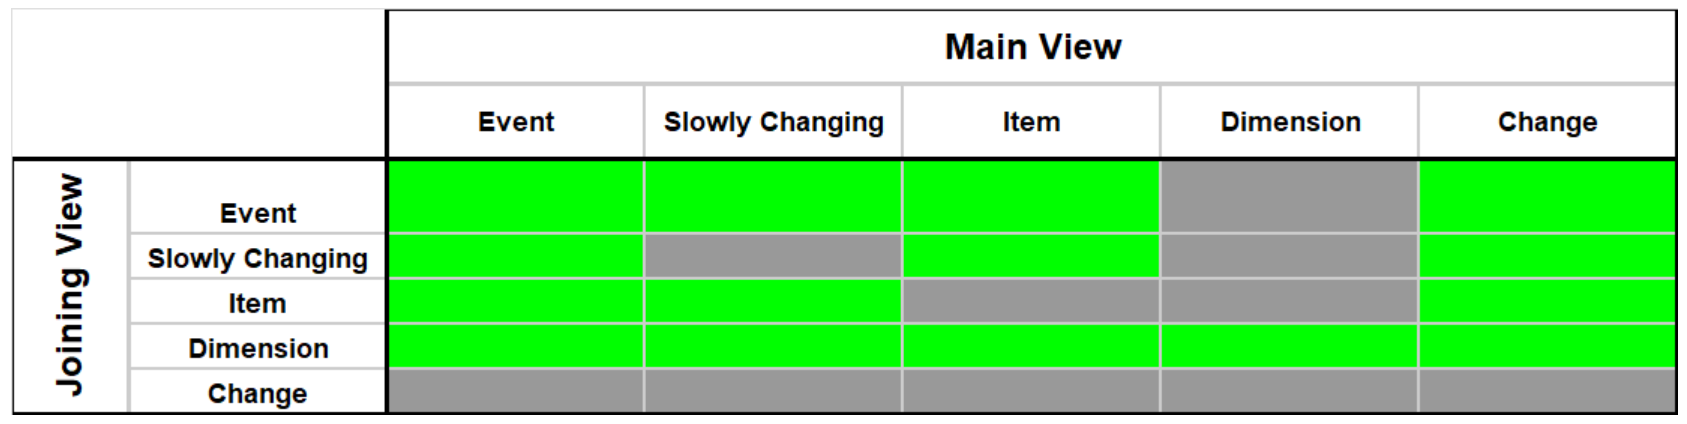

### Concept: Joins can be avoided

With featurebyte, you don't always need to join views to get the features you want.

1) <b>Entity relationships:</b> If a feature is calculated from a single table, and the entity level at which is calculated is the same as, or a parent of the entity level of your feature list, then featurebyte will use entity relationships to automatically apply that feature at the level of your feature list. For example, when state code is an entity, if you declare population of a US state as a feature, and your feature list operates at the customer entity level, featurebyte will know to use the state code of the customer to match the state population to the customer.
2) <b>Features built from features:</b> If a feature is calculated from attributes of more than one table, a user can first declare component features from each table, then declare a new feature that is a transformation of the combination of those component features. For example, you could declare a bank customer's income as a feature from the customer table, the average income per capita by US state as a feature from another table, then build a new feature that is the ratio of the bank customer's income to the state average.

## Next Steps

Now that you've completed the deep dive data modeling tutorial, you can put your knowledge into practice or learn more:<br>
1. Put your knowledge into practice by data modeling the cerdit card and healthcare datasets
2. Learn more about materializing features via the "Deep Dive Materializing Features" tutorial
3. Learn about managing features via the "Quick Start Feature Management" tutorial